In [11]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

### Gather performance and plotting

This script is to plot the prediction performance of different models (by GI types for Norman)

In [12]:
# load in data
dataset = 'norman_k562'
use_hvg = True
dataset_name = dataset + ('_hvg' if use_hvg else '_full')
latdim_ctrl = 50
latdim_ptb = 50
geneset_num = 50
val_ratio = 0.1
val_ood_ratio = 0.15

include_moe = False
test_set_name = 'predict_gi_fold' # '5_fold_split' or 'out_of_distribution_split'
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
tolerance_epoch = 20
# prior_list = ['Control_Gene_Expression', 'DepMap_GeneEffect', 'Geneformer', 'GenePT_v1', 'GenePT_v2_large', 'STRING']
prior = 'DepMap_GeneEffect'
model_type = 'mvae_attention_vae_14_3'

In [13]:
if test_set_name == '5_fold_split':
    if dataset == 'norman_k562':
         test_set_ids = ['random_split_1_2', 'random_split_2_2', 'random_split_3_2', 'random_split_4_2', 'random_split_5_2']
    else:
        test_set_ids = ['random_fold_1', 'random_fold_2', 'random_fold_3', 'random_fold_4', 'random_fold_5']
    random_seeds = [12]
elif test_set_name == 'predict_gi_fold':
    test_set_ids = ['predict_gi_fold_1', 'predict_gi_fold_2', 'predict_gi_fold_3', 'predict_gi_fold_4', 'predict_gi_fold_5']
    random_seeds = [12]

### Step 1. Read in all gene-level results in csv

In [14]:
gears_path = f'/home/che/GEARS/{dataset_name}'
vae_attention_path = f'/home/che/perturb-project/predict_model/result/rna/{dataset_name}'
salt_model_path = f'/home/che/perturb-project/git/gene_ptb_prediction/baseline_model/salt/{dataset_name}'
# control_distribution_path = f'/home/che/perturb-project/git/gene_ptb_prediction/baseline_model/predict_control/{dataset_name}_results.csv'

In [15]:
linear_model_df = pd.DataFrame()
gears_df = pd.DataFrame()
vae_attention_best_model_df = pd.DataFrame()

for test_set_id in test_set_ids:

    # load in GEARS results
    for random_seed in random_seeds:
        gears_path_temp = f'{gears_path}/{test_set_id}/random_seed_{random_seed}/evaluations.csv'
        gears_df_temp = pd.read_csv(gears_path_temp)
        gears_df_temp['model_type'] = 'GEARS'
        gears_df = pd.concat([gears_df, gears_df_temp])

    # load in SALT results
    for random_seed in random_seeds:
        salt_model_path_temp = f'{salt_model_path}/{test_set_id}_seed_{random_seed}_evaluations.csv'
        salt_model_df_temp = pd.read_csv(salt_model_path_temp)
        salt_model_df_temp['model_type'] = 'SALT'
        linear_model_df = pd.concat([linear_model_df, salt_model_df_temp])

    # load in VAE attention results
    for random_seed in random_seeds:
        vae_attention_path_parent_temp = (f'{vae_attention_path}/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}/{test_set_id}/recon_loss_mmd/null_label_{null_label}/epochs_100/'
                                          f'tolerance_epochs_{tolerance_epoch}/mxAlpha_2.0/val_{val_ratio}_ood_{val_ood_ratio}/random_seed_{random_seed}')
        pattern = f'{vae_attention_path_parent_temp}/{prior}_{model_type}_run*'
        vae_attention_path_temp = glob.glob(pattern)
        assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
        vae_attention_path_temp = vae_attention_path_temp[0]
        vae_attention_best_model_df_temp = pd.read_csv(f'{vae_attention_path_temp}/best_model_evaluations.csv')
        vae_attention_best_model_df_temp['model_type'] = 'MORPH'
        vae_attention_best_model_df = pd.concat([vae_attention_best_model_df, vae_attention_best_model_df_temp])

### Step 2. Put results together in one table and save as a csv file

In [16]:
columns_selected = ['pert', 'mmd', 'rmse', 'r2', 'pearsonr_change', 'fraction', 'model_type']

In [17]:
all_results_df = pd.concat([gears_df[columns_selected], 
                            linear_model_df[columns_selected],
                            vae_attention_best_model_df[columns_selected]], axis=0)

all_results_df.head(2)

,pert,mmd,rmse,r2,pearsonr_change,fraction,model_type
0,ZNF318+FOXL2,0.403225,0.152265,0.988654,0.816868,0.50,GEARS
1,DUSP9+KLF1,0.996020,0.380146,0.911009,0.922553,0.96,GEARS


In [18]:
all_results_df['model_name'] = all_results_df['model_type']

In [19]:
all_results_df[all_results_df['model_type'] == 'MORPH']['mmd'].mean(), all_results_df[all_results_df['model_type'] == 'MORPH']['mmd'].std()

(0.30411796678293634, 0.11778414708921307)

In [20]:
# save into a csv file 
result_folder = f'{dataset_name}'
result_folder += f'/{test_set_name}'
result_folder += f'/random_seed_{random_seed}'
result_folder += f'/null_label_{null_label}'
result_folder += f'/tolerance_epoch_{tolerance_epoch}'
result_folder += '/best_model'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
print(result_folder)

all_results_df.to_csv(f'{result_folder}/results.csv', index=False)

norman_k562_hvg/predict_gi_fold/random_seed_12/null_label_zeros/tolerance_epoch_20/best_model


### Step 3. Merge with GI information

In [21]:
# now read in gi_type
gi_path = '/home/che/perturb-project/data/norman_k562/norman_table/GI_gene_pair.csv'
gi_df = pd.read_csv(gi_path)
# rename synergy similar and synergy dissimilar to synergy
gi_df.loc[gi_df['Type'] == 'Strong Synergy (Dissimilar Phenotypes)', 'Type'] = 'synergy'
gi_df.loc[gi_df['Type'] == 'Strong Synergy (Similar Phenotypes)', 'Type'] = 'synergy'

# turn all into lower case
gi_df['Type'] = gi_df['Type'].str.lower()
print(gi_df['Type'].unique())

# create combinations of gene pairs
adata = sc.read_h5ad('/home/che/perturb-project/predict_model/dataset/norman_2019/Norman2019_normalized_hvg.h5ad')
all_ptb_targets = adata.obs['gene'].unique().tolist()
all_ptb_targets.remove('non-targeting')

for i, row in gi_df.iterrows():
    gene1 = row['Gene1']
    gene2 = row['Gene2']
    interaction_type = row['Type']
    pair1 = f'{gene1}+{gene2}'
    pair2 = f'{gene2}+{gene1}'
    if pair1 in all_ptb_targets:
        gi_df.loc[i, 'combination'] = pair1
    elif pair2 in all_ptb_targets:
        gi_df.loc[i, 'combination'] = pair2
    else:
        print(f'Pair {pair1} not found in gi_scores')

['neomorphic' 'additive' 'epistasis' 'redundant' 'potentiation' 'synergy'
 'suppressors']


Pair RHOXF2B+SET not found in gi_scores


In [22]:
gi_df.head(5)

,Type,Gene1,Gene2,combination
0,neomorphic,CBL,TGFBR2,CBL+TGFBR2
1,neomorphic,KLF1,TGFBR2,KLF1+TGFBR2
2,neomorphic,MAP2K6,SPI1,MAP2K6+SPI1
3,neomorphic,SAMD1,TGFBR2,SAMD1+TGFBR2
4,neomorphic,TGFBR2,CBARP,TGFBR2+CBARP


In [23]:
all_results_df = all_results_df.merge(gi_df[['combination', 'Type']], left_on='pert', right_on='combination', how='left')
all_results_df.head(5)

,pert,mmd,rmse,r2,pearsonr_change,fraction,model_type,model_name,combination,Type
0,ZNF318+FOXL2,0.403225,0.152265,0.988654,0.816868,0.50,GEARS,GEARS,NaN,NaN
1,DUSP9+KLF1,0.996020,0.380146,0.911009,0.922553,0.96,GEARS,GEARS,NaN,NaN
2,KLF1+CLDN6,0.925430,0.326294,0.940908,0.846898,0.80,GEARS,GEARS,NaN,NaN
3,UBASH3B+UBASH3A,0.295235,0.123661,0.987157,0.950304,0.96,GEARS,GEARS,NaN,NaN
4,RHOXF2+ZBTB25,0.483992,0.180305,0.977558,0.953023,0.80,GEARS,GEARS,NaN,NaN


In [24]:
# all_results_df[all_results_df['model_type'] == 'Gears'][all_results_df['Type'] == 'additive']

### Step 4. Plot results

In [25]:
grouped_data = all_results_df.groupby(["model_name", 'Type']).agg(
    mmd_mean=("mmd", "mean"),
    mmd_std=("mmd", "std"),
    r2_mean=("r2", "mean"),
    r2_std=("r2", "std"),
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    pearsonr_change_mean=("pearsonr_change", "mean"),
    pearsonr_change_std=("pearsonr_change", "std"),
    fraction_mean=("fraction", "mean"),
    fraction_std=("fraction", "std"),
    mmd_values=("mmd", lambda x: list(x))
).reset_index()
grouped_data

,model_name,Type,mmd_mean,mmd_std,r2_mean,r2_std,rmse_mean,rmse_std,pearsonr_change_mean,pearsonr_change_std,fraction_mean,fraction_std,mmd_values
0,GEARS,additive,0.732914,0.350343,0.899130,0.132295,0.259396,0.119163,0.875624,0.097922,0.801538,0.222180,"[0.5935425327883826, 0.4045186638832092, 0.909..."
1,GEARS,epistasis,0.652548,0.276448,0.902047,0.157440,0.244640,0.127689,0.830123,0.179074,0.746667,0.246374,"[0.6409724089834425, 0.5498382896184921, 0.639..."
2,GEARS,neomorphic,0.504411,0.236920,0.791553,0.370758,0.176096,0.078709,0.534577,0.462384,0.375000,0.212025,"[0.3649464646975199, 0.5259515941143036, 0.084..."
3,GEARS,potentiation,0.780606,0.130691,0.952039,0.008894,0.286932,0.042507,0.922467,0.042419,0.770000,0.147919,"[0.804532790184021, 0.6395184621214867, 0.7244..."
4,GEARS,redundant,0.828182,0.336589,0.807703,0.335795,0.246656,0.117585,0.701403,0.485006,0.567500,0.307792,"[1.211411190032959, 0.7820844501256943, 0.4925..."
5,GEARS,suppressors,0.634249,0.164393,0.936135,0.037681,0.236309,0.038848,0.669418,0.120108,0.670000,0.171093,"[0.5434349110493293, 1.0386048257350922, 0.712..."
6,GEARS,synergy,0.538010,0.194775,0.962233,0.058545,0.184152,0.073727,0.921644,0.063660,0.677500,0.262053,"[0.5751074075698852, 0.4710397660732269, 0.372..."
7,MORPH,additive,0.295929,0.097761,0.983960,0.011985,0.113166,0.042580,0.977221,0.013146,0.920000,0.188043,"[0.2982605003207502, 0.3185373947894214, 0.486..."
8,MORPH,epistasis,0.316498,0.179438,0.956382,0.105439,0.128354,0.116938,0.962867,0.034231,0.904444,0.120738,"[0.2463005428450428, 0.311724174528689, 0.2928..."
9,MORPH,neomorphic,0.258056,0.128973,0.818967,0.382711,0.109834,0.062108,0.792387,0.358227,0.746667,0.176704,"[0.0925637903680771, 0.2769346349232094, 0.161..."


In [26]:
grouped_data.to_csv(f'{result_folder}/sumamry_results_by_gi.csv', index=False)

In [27]:
desired_order_baseline = ['GEARS', 'SALT', 'MORPH']

### Plot MMD (distribution loss)

In [28]:
model_colors_baseline = {
            'Control\ndistribution': 'darkgrey',
            'GEARS': '#6baed6',
            'SALT': '#c4c2de',
            'MORPH': '#74c476',
        }

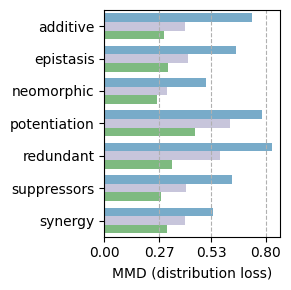

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming grouped_data is defined with the relevant data
np.random.seed(0)

# Simplified bar plot for MMD Mean
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Prepare the DataFrame for MMD
mmd_df = grouped_data.dropna(subset=['mmd_mean'])
desired_order = desired_order_baseline
model_colors = model_colors_baseline
mmd_df = mmd_df[mmd_df['model_name'].isin(desired_order)]
mmd_df['model_name'] = pd.Categorical(mmd_df['model_name'], categories=desired_order, ordered=True)
mmd_df = mmd_df.sort_values(['Type', 'model_name'])

# Customize plot size
fig_x = 3
fig_y = 3

# Draw figure using seaborn
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
sns.barplot(
    data=mmd_df,
    x='mmd_mean',
    y='Type',
    hue='model_name',
    palette=model_colors,
    ax=ax,
    ci=None,
    orient='h',
    errcolor='black',
    errwidth=0.3
)

# Set labels and limits
ax.set_ylabel('')
ax.set_xlabel('MMD (distribution loss)')
ax.set_xticks(np.round(np.linspace(0, 0.8, 4), 2))
ax.grid(False, axis='x', linestyle='--')
ax.legend_.remove()

# Save plot
plt.tight_layout()
plt.savefig(f'{result_folder}/mmd_plot_by_gi.png', dpi=300)
plt.savefig(f'{result_folder}/mmd_plot_by_gi.svg', format='svg')
plt.show()


In [30]:
# Create a separate legend plot
fig_legend = plt.figure(figsize=(6, 1))
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig_legend.legend(by_label.values(), by_label.keys(), loc='center', frameon=False, ncol=3)

# Save legend plot
fig_legend.tight_layout()
fig_legend.savefig(f'{result_folder}/mmd_plot_legend.png', dpi=300)
fig_legend.savefig(f'{result_folder}/mmd_plot_legend.svg', format='svg')
plt.show()

<Figure size 600x100 with 0 Axes>

### Plot RMSE (feature means)

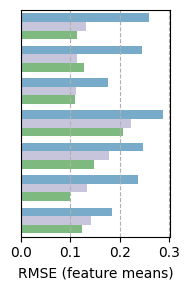

In [31]:
# Assuming grouped_data is defined with the relevant data
np.random.seed(0)

# Simplified bar plot for MMD Mean
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Prepare the DataFrame for rmse
plot_df = grouped_data.dropna(subset=['rmse_mean'])
desired_order = desired_order_baseline
model_colors = model_colors_baseline
plot_df = plot_df[plot_df['model_name'].isin(desired_order)]
plot_df['model_name'] = pd.Categorical(plot_df['model_name'], categories=desired_order, ordered=True)
plot_df = plot_df.sort_values(['Type', 'model_name'])

# Customize plot size
fig_x = 2
fig_y = 3

# Draw figure using seaborn
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
sns.barplot(
    data=plot_df,
    x='rmse_mean',
    y='Type',
    hue='model_name',
    palette=model_colors,
    ax=ax,
    ci=None,
    orient='h',
    errcolor='black',
    errwidth=0.3
)

# Set labels and limits
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlabel('RMSE (feature means)')
ax.set_xticks(np.round(np.linspace(0, 0.3, 4), 2))
ax.grid(False, axis='x', linestyle='--')
ax.legend_.remove()

# Save plot
plt.tight_layout()
plt.savefig(f'{result_folder}/rmse_plot_by_gi.png', dpi=300)
plt.savefig(f'{result_folder}/rmse_plot_by_gi.svg', format='svg')
plt.show()